In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

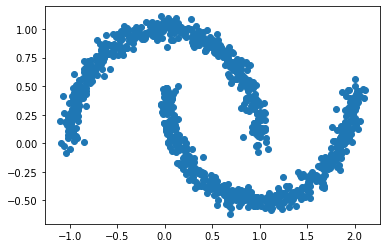

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x, y = datasets.make_moons(1000, noise=.05)
plt.scatter(x[:, 0], x[:, 1]);
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

/home/7jz/anaconda3/envs/flows/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  # This is added back by InteractiveShellApp.init_path()


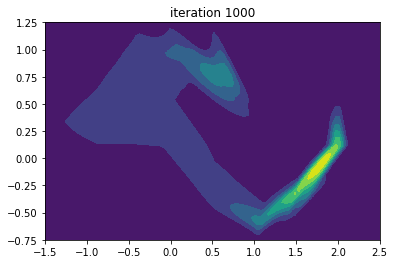

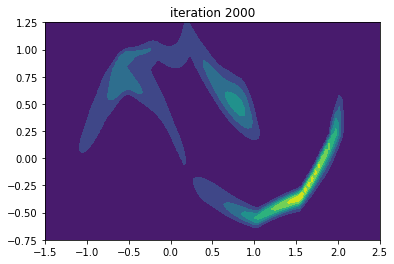

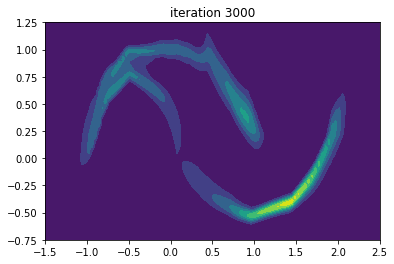

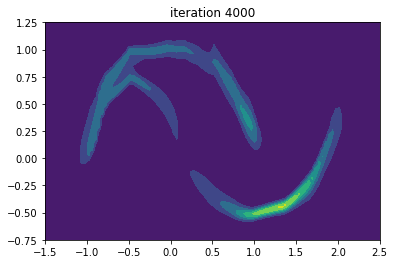

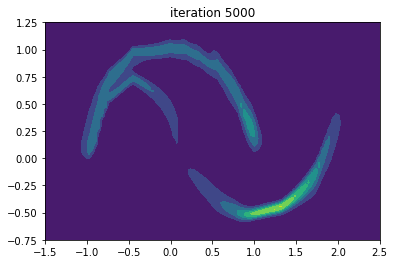

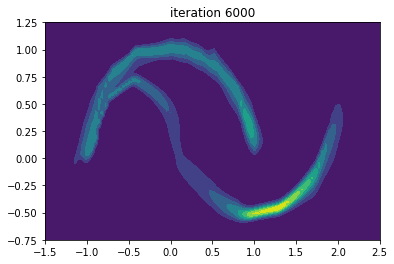

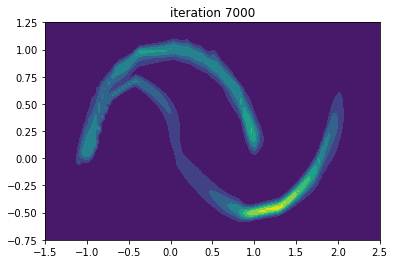

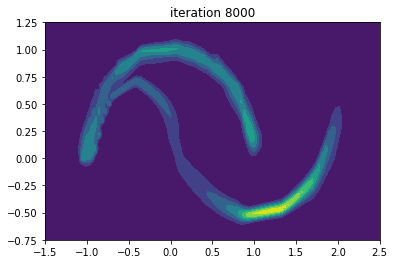

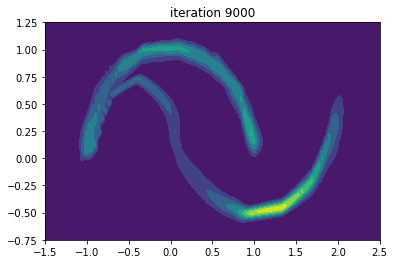

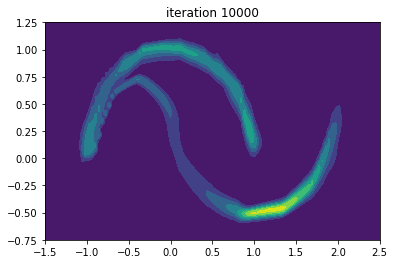

In [3]:
num_iter = 10000
for i in range(num_iter):
    x, y = datasets.make_moons(1000, noise=.05)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

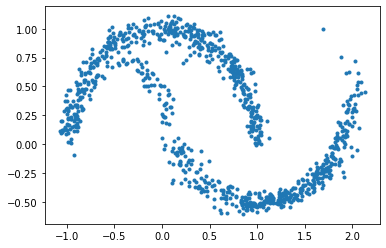

In [4]:
samples0 = flow.sample(1000)
samples = samples0.detach().numpy()
plt.plot(samples[:,0], samples[:,1],'.')